# CAB420, Neural Attention, Example 1: Attention and RNNs
Dr Simon Denman (s.denman@qut.edu.au)

# Overview

The idea of attention is to learn which parts of the input (or of some internal representation) are most relevant, and to try to direct the network towards these parts. There are very many different variations on attention, but the general approach can be summarised as:
* Learn an additional layer that will consider the importance of locations within an input
* Use this learned importance to weight the input/representation such that more important regions are more prominent

Attention actually first emerged in text processing, and this example will quickly explore how we can use a simple attention layer within an LSTM network for classifying tweets.

## Too Long; Didn't Read:
* Attention is effectively an additional layer, learned with the rest of the network. While we can hand-craft attention rules, this is generally less desireable as it requires us to make assumptions on what is important in the data, rather than learn directly from the data
* We can set attention up in many different ways, for example we:
  * can consider each location independantly
  * can weight locations based on the relationship between the location itself and all other locations
  * can vary the activations used to be more or less selective (i.e. select more or fewer regions as being important)
  * can use one input/representation to direct attention for a different input/representation (note, this is not shown in this example)
* We can use attention in multiple locations within a network
* Depending on the formulation, attention is something that is fairly easy to visualise, and can help us understand what the network is doing (or at least, what a small part of the network is doing)
* Provided we are not too selective with what information we allow to flow through, attention will generally improve performance
  * If we get too selective, we can reduce information flow too much. In such cases not enough information will reach later layers, and this will hamper (or even prevent) learning

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import pandas
import numpy
import matplotlib.pyplot as plt

import tensorflow as tf
import keras

from keras.preprocessing.sequence import pad_sequences
import keras_nlp
from keras import layers
from keras.utils import model_to_dot, plot_model

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import seaborn

## The Data
Still twitter data. Same setup as last time - though we're taking a few more samples as we're training a NN.

In [2]:
tweets = pandas.read_csv('../data/sentiment140/training.1600000.processed.noemoticon.csv')
print(tweets.head())

tweet_text = tweets.iloc[:, -1].tolist()
Y = numpy.array(tweets.iloc[:, 0])
Y[Y > 0] = 1

num_samples = 60000
train_samples = 50000
samples = numpy.random.choice(len(Y), num_samples)

train_X = [tweet_text[i] for i in samples[0:train_samples]]
train_Y = Y[samples[0:train_samples]]
test_X = [tweet_text[i] for i in samples[train_samples:]]
test_Y = Y[samples[train_samples:]]
print(numpy.shape(train_X))
print(numpy.shape(train_Y))
print(numpy.shape(test_X))
print(numpy.shape(test_Y))

   0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY _TheSpecialOne_  \
0  0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   scotthamilton   
1  0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY        mattycus   
2  0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY         ElleCTF   
3  0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          Karoli   
4  0  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY        joy_wolf   

  @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D  
0  is upset that he can't update his Facebook by ...                                                                   
1  @Kenichan I dived many times for the ball. Man...                                                                   
2    my whole body feels itchy and like its on fire                                                                    
3  @nationwideclass no, it's not behaving at all....           

### Data Preperation

This is as per our examples on sequences. 

We need to get our data into something numeric. Previously when we've played with text data, this has meant:
* text embeddings
* bag of words

We'll use an embedding again, but rather than use gensim and train one there, we'll build one as part of network. We still have some pre-processing to do though, and we'll do this through a tensorflow data object. We can use some keras functions to do all our pre-processing too, and we'll wrap that all up in a tensorflow dataset.

In [3]:
maxwords = 20000
batch_size = 64
# I don't expect to see tweets 96 words long, we we're not looking at words - we're looking at word parts.
sequence_length = 96

training_data_text = tf.data.Dataset.zip(tf.data.Dataset.from_tensor_slices(train_X),
                                         tf.data.Dataset.from_tensor_slices(train_Y))
testing_data_text = tf.data.Dataset.zip(tf.data.Dataset.from_tensor_slices(test_X),
                                        tf.data.Dataset.from_tensor_slices(test_Y))

# train a vocabulary on the words
# note here we're using word pieces - not whole words. This has become the standard approach
# for deep learning (see https://paperswithcode.com/method/wordpiece)
vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
    training_data_text.map(lambda x, y: x),
    vocabulary_size=maxwords,
    lowercase=True,
    strip_accents=True,
    split = False,
    reserved_tokens=["[PAD]", "[START]", "[END]", "[MASK]", "[UNK]"],)

# tokenizer layer. We could build this into our network, but we'll do it outside the network as part of our data
# pipeline
tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    # pass in the vocab that we train
    vocabulary=vocab,
    lowercase=True,
    strip_accents=True,
    oov_token="[UNK]",)

# a "packer" layer, that will "pack" our strings with a start and end token to denote the start and end of the string,
# and then pad strings to be a consistent length
packer = keras_nlp.layers.StartEndPacker(
    start_value=tokenizer.token_to_id("[START]"),
    end_value=tokenizer.token_to_id("[END]"),
    pad_value=tokenizer.token_to_id("[PAD]"),
    sequence_length=sequence_length,)

# pre-process function to wrap everything up, tokenize and pack strings
def preprocess(x, y):
    token_ids = packer(tokenizer(x))
    return token_ids, y

# apply pre-processing to data
# then set the batch size ready to pass into our networks
training_data_mapped = training_data_text.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE).batch(batch_size)
testing_data_mapped = testing_data_text.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE).batch(batch_size)

## A Recurrent Neural Network

We'll start by setting up a baseline network to compare to. This will be very similar to our earlier LSTM based networks. We'll use two LSTMs. The first will be a sequence-to-sequence LSTM, the second of will just output a single vector and we can classify that directly. Our attention will sit between the two LSTMs.

In [4]:
inputs = keras.Input(shape=(None,), dtype="int32")
x = layers.Embedding(maxwords, 128)(inputs)
x = layers.LSTM(64, return_sequences=True, return_state=False)(x)
x = layers.LSTM(64, return_sequences=False, return_state=False)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)

model.summary()

model.compile("adam", "binary_crossentropy", metrics=["accuracy"], jit_compile=False)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ embedding (Embedding)           │ (None, None, 128)         │  2,560,000 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm (LSTM)                     │ (None, None, 64)          │     49,408 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)                │     33,024 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 1)                 │         65 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 2,642,497 (10.08 MB)

 Trainable params: 2,642,497 (10.08 MB)

 Non-trainable params: 0 (0.00 B)

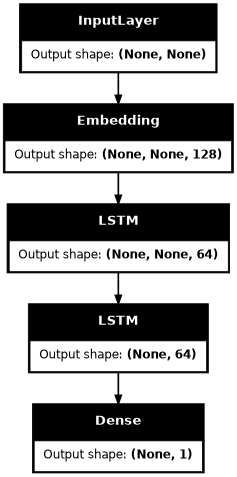

In [5]:
plot_model(model, show_shapes=True, dpi=60)

In [6]:
epochs = 30

model.fit(training_data_mapped,
          epochs=epochs,
          validation_data=testing_data_mapped, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, start_from_epoch=10)])

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.4990 - loss: 0.6933 - val_accuracy: 0.5992 - val_loss: 0.6817
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5193 - loss: 0.6920 - val_accuracy: 0.4976 - val_loss: 0.6943
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5020 - loss: 0.6933 - val_accuracy: 0.5081 - val_loss: 0.6932
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5265 - loss: 0.6902 - val_accuracy: 0.5778 - val_loss: 0.6785
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5901 - loss: 0.6730 - val_accuracy: 0.6269 - val_loss: 0.6528
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6353 - loss: 0.6405 - val_accuracy: 0.6510 - val_loss: 0.6281
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6596 - loss: 0.6183 - val_accuracy: 0.6644 - val_loss: 0.6089
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6751 - loss: 0.5997 - val_acc

Now we can evaluate the model, and we see that it works pretty well.

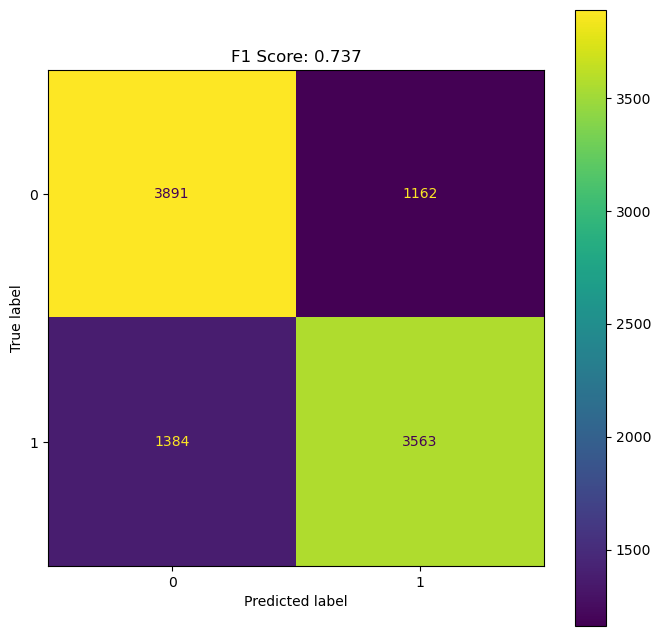

In [7]:
def eval_model(model, x_test, y_test):  
    
    # make predictions
    pred = model.predict(x_test, verbose=False);
    # apply threshold, just pick 0.5
    pred = pred >= 0.5

    # get confusion matrix and F1
    cm = confusion_matrix(y_test, pred)
    fig = plt.figure(figsize=[8, 8])
    ax = fig.add_subplot(1, 1, 1)
    c = ConfusionMatrixDisplay(cm, display_labels=range(2))
    c.plot(ax = ax)    
    ax.set_title("F1 Score: %1.3f" % f1_score(y_test, pred))

# pull out TF dataset as a numpy array to make it easy to get F1 Score and Confusion Matrix
test_tokens = []
test_labels = []

for i, (x, y) in enumerate(testing_data_mapped.as_numpy_iterator()):
    test_tokens.extend(x)
    test_labels.extend(y)
    
test_tokens = numpy.array(test_tokens)
test_labels = numpy.array(test_labels)

# evaluate
eval_model(model, test_tokens, test_labels)

## Adding Attention

Attention mechanisms come in many, many, variations. We'll keep it fairly simple here, but if you want to see a few more options go check out ``CAB420_Neural_Attention_Bonus_Example_Attention_and_DCNNs.ipynb``. 

First up, we'll create a model that aims to assess each word, and decide how important that word is for our task (sentiment classification). As such, we'll add a layer to analyse a word and ouptut a single value indicating importance. We can then get those values for each word, standardise them in some way, and multiply them by the original embedding.

In [8]:
inputs = keras.Input(shape=(None,), dtype="int32")
x = layers.Embedding(maxwords, 128)(inputs)
x = layers.LSTM(64, return_sequences=True, return_state=False)(x)

# attention mechanism starts here
# This layer will look at each word, and output a single value to indicate it's importance
e = layers.Dense(1, activation='tanh')(x)
# flatter the word level importance
e = layers.Flatten()(e)
# apply a softmax to the word importance vectors
a = layers.Activation('softmax', name='attention')(e)
# we need to now multiply the word importance vector by the input to our attention process, x
# x is of shape [64, num_words], so we need 64 copies of our attention vector
temp = layers.RepeatVector(64)(a)
# get the dimensions in the correct order
temp = layers.Permute([2, 1])(temp)
# multiply our input by our attention vector
x = layers.Multiply()([x, temp])
# continue on with the network

x = layers.LSTM(64, return_sequences=False, return_state=False)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)

model.summary()

model.compile("adam", "binary_crossentropy", metrics=["accuracy"], jit_compile=False)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None)      │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ embedding_1         │ (None, None, 128) │ 2,560,… │ input_layer_1[0][0]  │
│ (Embedding)         │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ lstm_2 (LSTM)       │ (None, None, 64)  │  49,408 │ embedding_1[0][0]    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_1 (Dense)     │ (None, None, 1)   │      65 │ lstm_2[0][0]         │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ flatten (Flatten)   │ (None, None)      │       0 │ dense_1[0][0]        │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ attention           │ (None, None)      │       0 │ flatten[0][0]        │
│ (Activation)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ repeat_vector       │ (None, 64, None)  │       0 │ attention[0][0]      │
│ (RepeatVector)      │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ permute (Permute)   │ (None, None, 64)  │       0 │ repeat_vector[0][0]  │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ multiply (Multiply) │ (None, None, 64)  │       0 │ lstm_2[0][0],        │
│                     │                   │         │ permute[0][0]        │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ lstm_3 (LSTM)       │ (None, 64)        │  33,024 │ multiply[0][0]       │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      65 │ lstm_3[0][0]         │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 2,642,562 (10.08 MB)

 Trainable params: 2,642,562 (10.08 MB)

 Non-trainable params: 0 (0.00 B)

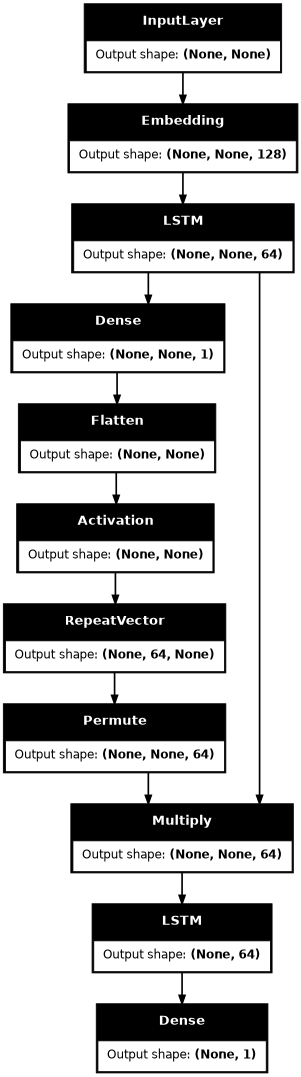

In [9]:
plot_model(model, show_shapes=True, dpi=60)

The trickest part of our attention mechanism is (I think) the repeat and reshape bit. Let's break down the layers one by one:
* the input to our attention block (lstm_2) has shape (None, None, 64), which means (batch_size, sequence_length, 64). What we want to do is learn some mask to apply to this representation that emphasises important things. Thus, we need to end up with a mask that's also (batch_size, sequence_length, 64).
* dense_1 takes our representation from (batch_size, sequence_length, 64) to (batch_size, sequence_length, 1), we're getting a single value to capture the importance of each word. This really is the attention score right here.
* flatten_1 drops the last dimension, so we now have (batch_size, sequence_length) as our representation. This is critical for the next layer to work properly.
* activation is next, and here we're using softmax. What we want to do is run the softmax over each sequence, so the attention scores for each sequence sum to 1. If we didn't have the above flatten, our softmax would be applied to each (batch_size, sequence_length, 1) cell, which would just mean that every attention score would be. By using the above flatten, we get a shape that will allow us to run the softmax across the sequence, normalising the important words. At this point we have our normalised attention scores, so we need to get back from a (batch_size, sequence_length) shape to (batch_size, sequence_length, 64) so we can combine the attention scores with the input. All we want to do is stack 64 of these (batch_size, sequence_length) things, such that the size 64 embedding for each word is multiplied by a constant weight
* repeat_vector does the first part of what we need, repeating the vector 64 times, but it puts things in the wrong order, giving us (batch_size, 64, sequence_length) rather than (batch_size, sequence_length, 64)
* permute finishes the job, swapping the last two dimensions to get a (batch_size, sequence_length, 64) representation
* Finally, we have the multiply layer, that simply multiplies the data representation by the attention scores.

There are a lot of things we can change about this. For example:
* We could use a different activation for our attention scores, such as a sigmoid
* We could use addition rather than multiplication to combine our attention scores with our representation
* We could compute the attention scores in a different way

We could also wrap all of the operations up in a single layer, rather than the combination we've used above.

In [10]:
model.fit(training_data_mapped,
          epochs=epochs,
          validation_data=testing_data_mapped, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, start_from_epoch=10)])

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.4983 - loss: 0.6933 - val_accuracy: 0.5711 - val_loss: 0.6816
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.5799 - loss: 0.6797 - val_accuracy: 0.5813 - val_loss: 0.6776
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.5830 - loss: 0.6750 - val_accuracy: 0.6209 - val_loss: 0.6584
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.6071 - loss: 0.6571 - val_accuracy: 0.6336 - val_loss: 0.6328
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.6439 - loss: 0.6337 - val_accuracy: 0.6317 - val_loss: 0.6476
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.6347 - loss: 0.6403 - val_accuracy: 0.6471 - val_loss: 0.6305
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.6508 - loss: 0.6284 - val_accuracy: 0.6561 - val_loss: 0.6190
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.6586 - loss: 0.6220 - val_acc

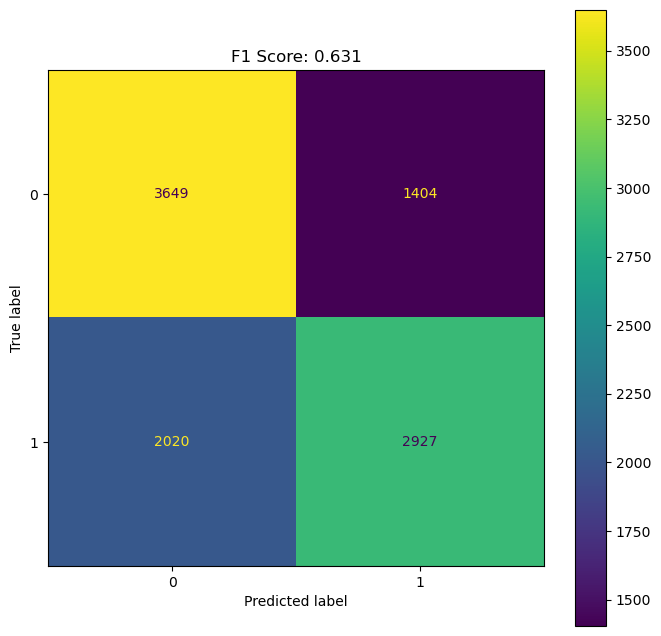

In [11]:
eval_model(model, test_tokens, test_labels)

Our model works ok. We're not getting a huge change here, as we're already somewhat up against the limit with this data, and the fact that our sequences are small means that the LSTMs were able to do a fairly good job of keeping track of what was in the sequence already (for more dramatic results, see ``CAB420_Neural_Attention_Bonus_Example_Attention_and_DCNNs.ipynb``).

### Visualising Attention

One nice thing that we can now do though is visualise the attention scores. We can pull this result out of the network, and essentially see what the network thinks is important.

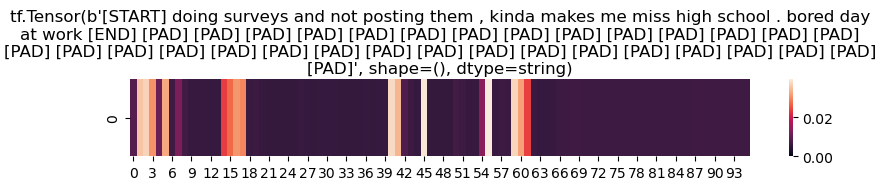

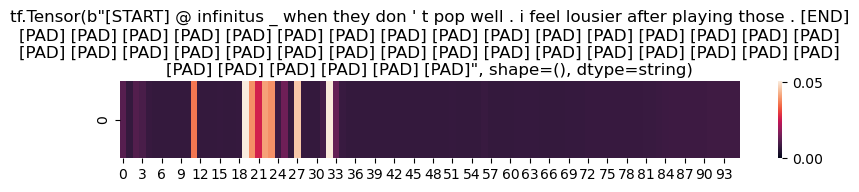

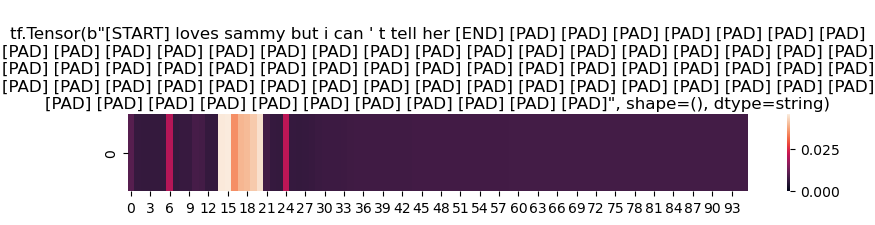

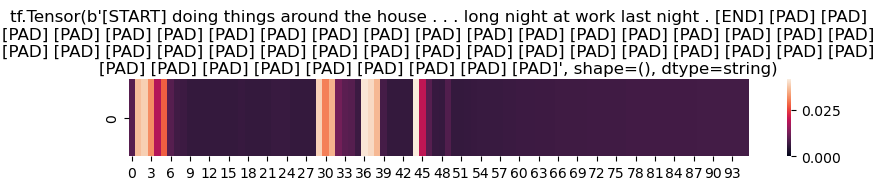

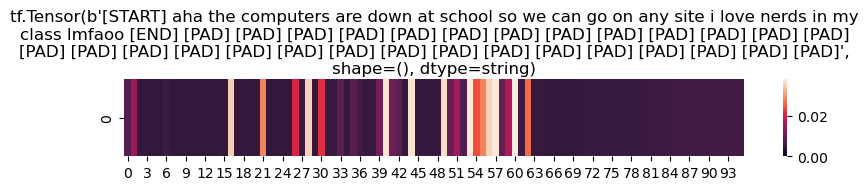

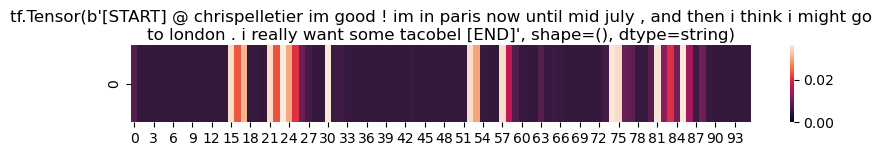

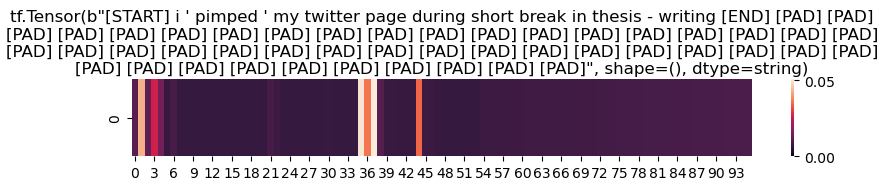

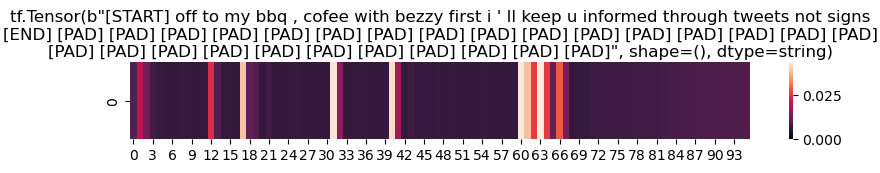

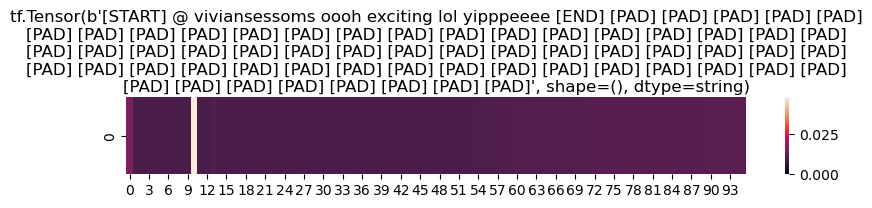

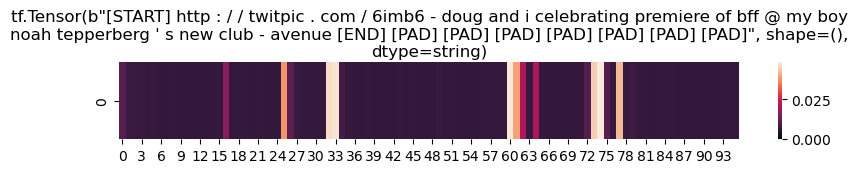

In [12]:
layer_name = 'attention'
intermediate_layer_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer(layer_name).output)

def visualise_attention(intermediate_layer_model, tokens, text, start_pos):
    for i in range(10):
        intermediate_output = numpy.array(intermediate_layer_model(tokens[i+start_pos:i+start_pos+1,:]))
        fig = plt.figure(figsize=[10, 1])
        ax = fig.add_subplot(1, 1, 1)
        g = seaborn.heatmap(intermediate_output,vmin=0)
        ax.set_title(text[i+start_pos], wrap=True)
       
it = iter(testing_data_mapped)
batch = next(it)
text = tokenizer.detokenize(batch[0])

visualise_attention(intermediate_layer_model, batch[0], text, 0)

From the above, we see that what's important varies across the tweets - which is good. This is what we'd expect as not all tweats are equal, and the key words (or word parts more correctly as we're using word part tokenisation) and their placement with respect to sentiment will vary. 

When looking at the plots, keep in mind that each slot in our attention vector does not correspond to a word exactly - or even a word part - rather it corresponds to the output of the LSTM up to that point in the sequence. So the fourth slot is the embedding that arises after the fourth word is processed, and thus depends on the first four words. Perhaps with that in mind, it's better to think of these are showing important "parts" of the input rather than specific words. A large step change in importance indicates that we've suddenly seen a word that's particularly important (or un-important) in the context of the tweet.

### Sigmoid rather than Softmax

For science, we'll now change our softmax activation to a sigmoid. This should allow a little more information to flow, but will also do less in terms of identifying the most important word or two in the tweet.

This really is very similar to our first network, with just a change to the activations.

In [13]:
inputs = keras.Input(shape=(None,), dtype="int32")
x = layers.Embedding(maxwords, 128)(inputs)
x = layers.LSTM(64, return_sequences=True, return_state=False)(x)

# attention mechanism starts here
# again we have a dense layer to look at individual words, but we now have a sigmoid here
e = layers.Dense(1, activation='sigmoid')(x)
# now starts the shape manipulation. We need to weight each word in the original embedding (x)
# by the attention weight, so do to this we will do a flatten, repeat the vector 64 times (size
# of the embedding), and finally adjust the dimensions
a = layers.Flatten(name='attention')(e)
temp = layers.RepeatVector(64)(a)
temp = layers.Permute([2, 1])(temp)
# now we can multiply our attention weight by the input vector
x = layers.Multiply()([x, temp])
# and we can use the augmented embedding in the rest of the network

x = layers.LSTM(64, return_sequences=False, return_state=False)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)

model.summary()

model.compile("adam", "binary_crossentropy", metrics=["accuracy"], jit_compile=False)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None)      │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ embedding_2         │ (None, None, 128) │ 2,560,… │ input_layer_2[0][0]  │
│ (Embedding)         │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ lstm_4 (LSTM)       │ (None, None, 64)  │  49,408 │ embedding_2[0][0]    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_3 (Dense)     │ (None, None, 1)   │      65 │ lstm_4[0][0]         │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ attention (Flatten) │ (None, None)      │       0 │ dense_3[0][0]        │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ repeat_vector_1     │ (None, 64, None)  │       0 │ attention[0][0]      │
│ (RepeatVector)      │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ permute_1 (Permute) │ (None, None, 64)  │       0 │ repeat_vector_1[0][… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ multiply_1          │ (None, None, 64)  │       0 │ lstm_4[0][0],        │
│ (Multiply)          │                   │         │ permute_1[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ lstm_5 (LSTM)       │ (None, 64)        │  33,024 │ multiply_1[0][0]     │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │      65 │ lstm_5[0][0]         │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 2,642,562 (10.08 MB)

 Trainable params: 2,642,562 (10.08 MB)

 Non-trainable params: 0 (0.00 B)

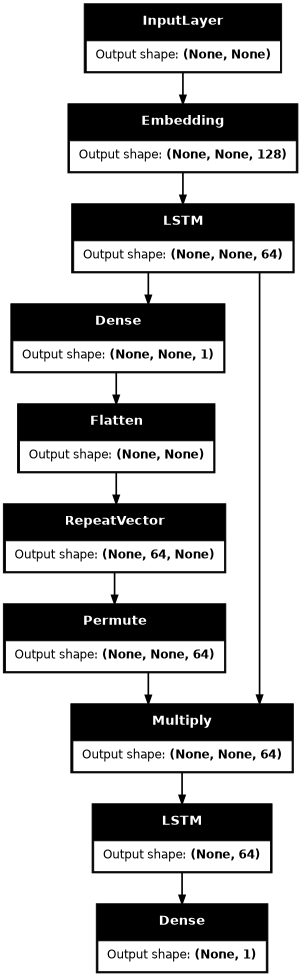

In [14]:
plot_model(model, show_shapes=True, dpi=60)

In [15]:
model.fit(training_data_mapped,
          epochs=epochs,
          validation_data=testing_data_mapped, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, start_from_epoch=10)])

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.4998 - loss: 0.6934 - val_accuracy: 0.4976 - val_loss: 0.6931
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.5351 - loss: 0.6885 - val_accuracy: 0.4935 - val_loss: 0.6949
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.4992 - loss: 0.6937 - val_accuracy: 0.4935 - val_loss: 0.6944
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.4994 - loss: 0.6936 - val_accuracy: 0.4935 - val_loss: 0.6940
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.4981 - loss: 0.6935 - val_accuracy: 0.4935 - val_loss: 0.6938
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.4986 - loss: 0.6935 - val_accuracy: 0.4935 - val_loss: 0.6937
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.4999 - loss: 0.6934 - val_accuracy: 0.4935 - val_loss: 0.6936
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.4999 - loss: 0.6934 - val_acc

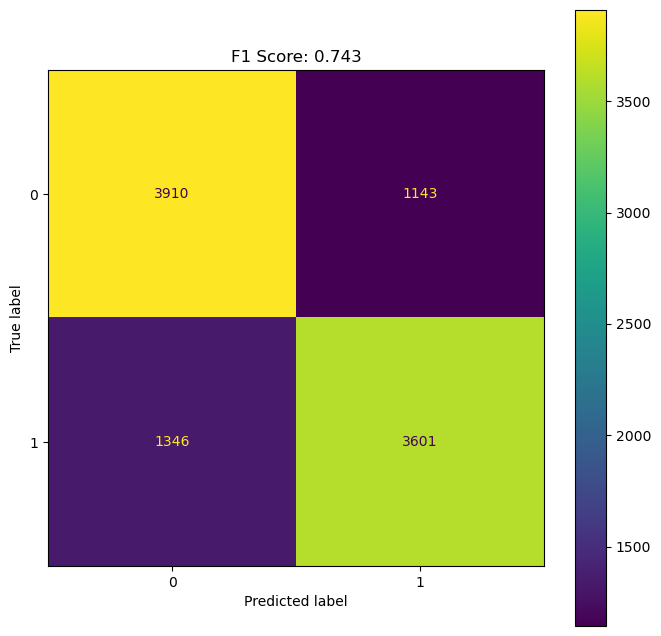

In [16]:
eval_model(model, test_tokens, test_labels)

Performance wise, we're at about the same point as before.

Let's visualise some activations now.

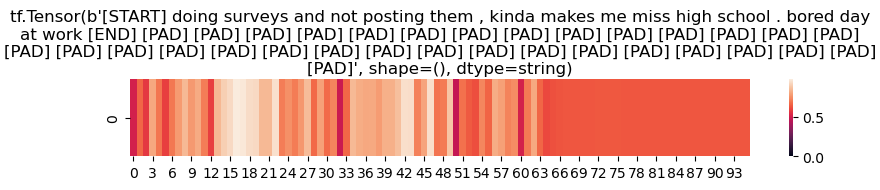

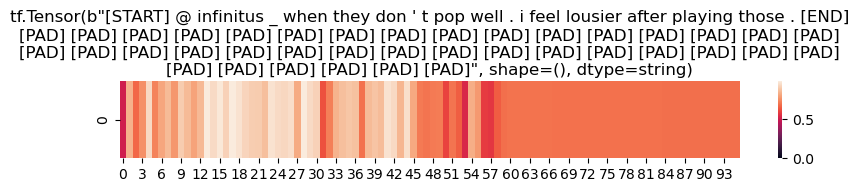

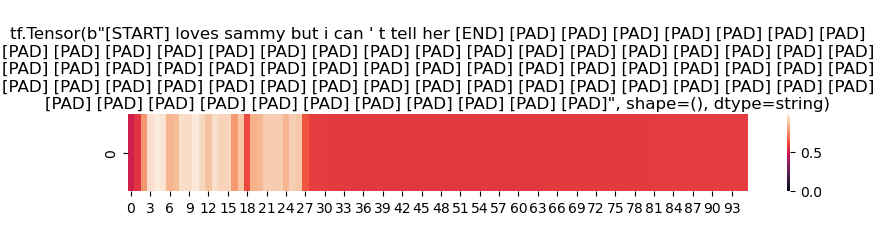

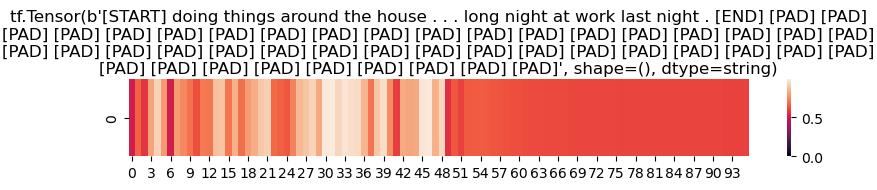

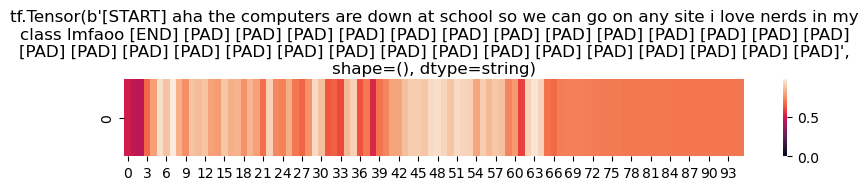

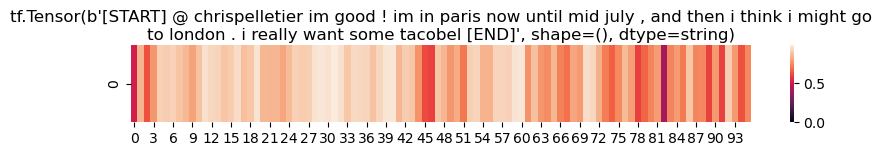

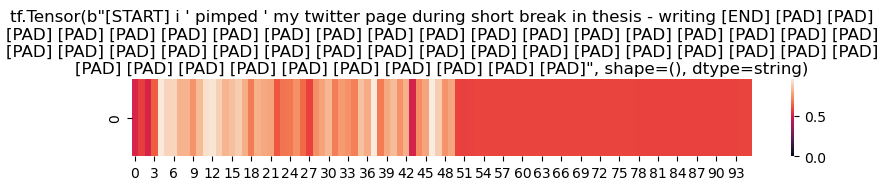

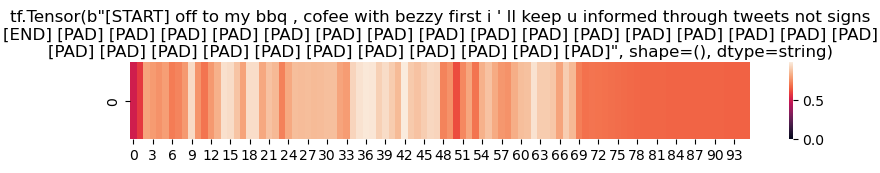

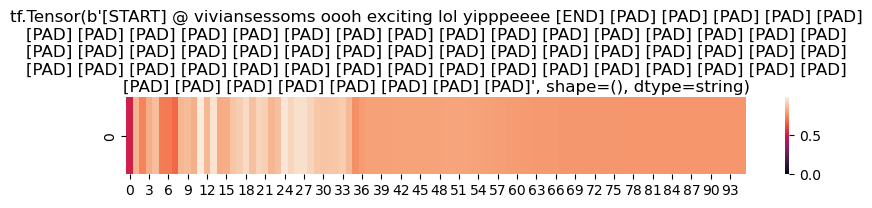

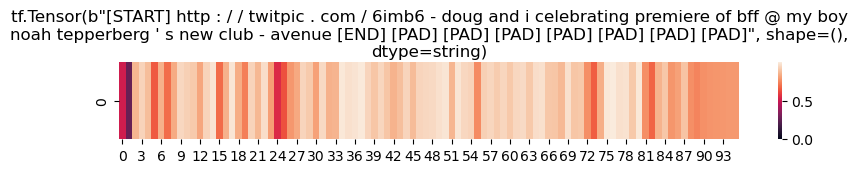

In [17]:
layer_name = 'attention'
intermediate_layer_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer(layer_name).output)
        
visualise_attention(intermediate_layer_model, batch[0], text, 0)

We can see similar patterns of behaviour here to what we saw with our softmax output, though a lot less dramatic in terms of variation in importance, with most of the tweet other than the first couple of bits deemed to be important. Overall the sigmoid activation allows the model to identify more of the tweet as being important, so we're being less selective in terms of what information we pull out.

## Final Thoughts

In this example, we've looked at a simple way to incorporate attention into a recurrent network, and applied this to our twitter data. 

In this case it hasn't resulted in any major performance gain, which we can attribute to:
* Our non-attention network already doing well
* The tweets being fairly short, thus being modelled quite well by the LSTM
* The ambiguity in the data making higher performance tricky

Longer sequences will lead to larger benefits, though even with these small sequences the ability to visualise the attention and help understand what is being focussed on is valuable. We should also note that for simplicity, we've not looked at using a bi-directional network here, though again we could add this and use attention which may help improve performance a little bit more.